In [16]:
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.transform import rotate
import numpy as np
from python.general_functions import show_images, normalize_img
from skimage.color import rgb2gray
from python.sift_extractor import SIFT
from sklearn.neighbors import NearestNeighbors
import cv2

We will be using functions defined in `RANSANC_Homograpy_Stitching.ipynb` notebook
(compute_homography_matrix, stitch_two_images, find_bounding_box)

In [17]:
def compute_homography_matrix(src_sift, dst_sift, nearest_neighbors_model, threshold_distance=0.7):
    '''calculates homography matrix of transforming source image to destination image'''
    
    # Find nearest neighbors for each descriptor in the source keypoints
    distances, indices = nearest_neighbors_model.kneighbors(src_sift["Descriptor"].to_list())

    # Filter indices based on the threshold distance
    filtered_indices = indices[distances < threshold_distance].ravel()

    # Extract corresponding points from the source and target keypoints
    source_points = np.array(src_sift.iloc[distances < threshold_distance]['Position'].to_list())[:, :2]
    target_points = np.array(dst_sift.take(filtered_indices)['Position'].to_list())[:, :2]

    # Estimate homography matrix using RANSAC
    # computes the homography matrix (H) to transform points from the source image (srcPoints) to the destination image (dstPoints)
    homography_matrix, _ = cv2.findHomography(source_points.astype(np.float32), target_points.astype(np.float32), 
                                              cv2.RANSAC, ransacReprojThreshold=5)

    return homography_matrix

def stitch_two_images(img1, img2, x_offset=0, img1_left=False):
    """
    Stitch two images horizontally.

    Parameters:
    - img1: First input image to be stitched.
    - img2: Second input image to be stitched.
    - x_offset: Horizontal offset to adjust the stitching position of img1.
    - img1_left: Boolean indicating whether img1 is on the left (True) or right (False).

    Returns:
    - result_image: The stitched image.
    """
    # Normalize input images
    img1 = normalize_img(img1)
    img2 = normalize_img(img2)

    # Get dimensions of img1
    h1, w1 = img1.shape[:2]

    # Create an identity transformation matrix with horizontal offset
    m = np.eye(3)
    m[0, 2] = x_offset

    # Warp img1 using the transformation matrix
    img1_warped = cv2.warpPerspective(img1, m, (w1 + x_offset, h1))

    # Initialize the stitched image with zeros
    stitched_img = np.zeros(img2.shape)

    # Place the warped img1 on the left or right side of the stitched image
    if img1_left:
        stitched_img[:, :w1 + x_offset] = img1_warped
    else:
        stitched_img[:, :w1] = img1_warped

    # Create masks for pixels with values in both images
    mask_both = np.all((stitched_img != 0, img2 != 0), axis=0)

    # Create a new image by taking the mean of pixels with values in both images
    mean_image_both = np.zeros_like(img2, dtype=np.float32)
    mean_image_both[mask_both] = (stitched_img[mask_both] + img2[mask_both]) / 2

    # Create a new image by adding other pixels together
    result_image = stitched_img + img2

    # Combine the two images by replacing pixels with mean values
    result_image[mask_both] = mean_image_both[mask_both]

    return result_image

def find_bounding_box(img):
    """
    Find the bounding box of the main object in a binary or grayscale image.

    Parameters:
    - img: Input image (binary or grayscale).

    Returns:
    - x: X-coordinate of the top-left corner of the bounding box.
    - y: Y-coordinate of the top-left corner of the bounding box.
    - w: Width of the bounding box.
    - h: Height of the bounding box.
    """

    # Convert the image to grayscale if it's in RGB format
    if len(img.shape) > 2:
        gray = rgb2gray(img)
    else:
        gray = img.copy()

    # Convert the grayscale image to a binary mask
    binary_mask = cv2.threshold(gray * 255, 1, 255, cv2.THRESH_BINARY)[1]
    binary_mask = binary_mask.astype(np.uint8)

    # Make a copy of the binary mask
    binary_mask = binary_mask.copy()

    # Define a kernel for morphological closing to fill small holes
    closing_kernel = np.ones((15, 15), np.uint8)

    # Apply closing to the binary mask
    result_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, closing_kernel)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(result_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (main object)
    max_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box coordinates
    x, y, w, h = cv2.boundingRect(max_contour)

    # Get the initial mask at bounding box coordinates
    mask = result_mask[y:y+h, x:x+w]

    # Iterate to refine the bounding box by adjusting its position
    while np.any(mask == 0):
        # Save the previous state of the mask
        prev_mask = mask.copy()

        # Adjust the bounding box
        x += 2
        y += 2
        w -= 4  # Decrease width by 4 to adjust for both sides
        h -= 4  # Decrease height by 4 to adjust for both top and bottom
        mask = result_mask[y:y+h, x:x+w]

        # Check if the adjustment changed the mask
        if np.array_equal(mask, prev_mask):
            break

    return x, y, w, h

Shape = (833, 2400, 3)


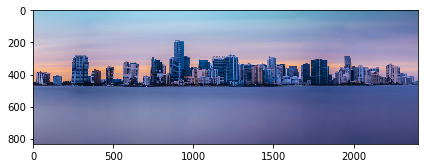

In [18]:
# read a panorama image
img = io.imread("img4.jpg")
print(f"Shape = {img.shape}")
io.imshow(img)
plt.show()

In [19]:
# split img into mutliple images and rotate them by a degree from -10 to 10
img_splits = []
width = 600
for i in range(8):
    angle = np.random.randint(-10, 10)
    img_splits.append(rotate(img[:, 250 * i : width + 250 * i], angle, mode='edge'))

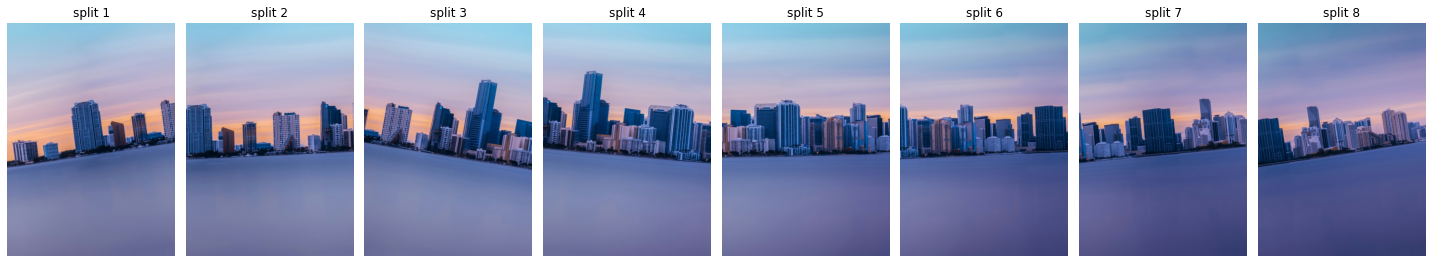

In [20]:
show_images(img_splits, [f"split {i+1}" for i in range(len(img_splits))], show_axis=False)

In [21]:
# Convert rgb images to gray
gray_img_splits = [rgb2gray(i) for i in img_splits]

In [22]:
# get sift descriptor for each img
sift_data = []
sift_ = SIFT(num_downsamples=0)
for img_ in gray_img_splits:
    sift_summary = sift_.extract_sift_data(img_)
    sift_data.append(sift_summary)

In [23]:
affine_matrices = []

# get affine matrix between img i and img i-1
for i in range(1, len(gray_img_splits)):
    img1 = np.uint8(gray_img_splits[i-1] * 255)
    img2 = np.uint8(gray_img_splits[i] * 255)

    k_neighbors = 1
    model = NearestNeighbors(n_neighbors=k_neighbors)

    src_sift = sift_data[i-1]
    dst_sift = sift_data[i]

    model.fit(dst_sift["Descriptor"].to_list());

    a_m = compute_homography_matrix(src_sift, dst_sift, model, 1)
    affine_matrices.append(a_m)
    affine_matrices = np.array(affine_matrices)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [ ]:
def stitch_backward(current_image, previous_image, accumulated_affine_matrix, offset=0, is_left=False):
    output_size = (previous_image.shape[1] + current_image.shape[1], previous_image.shape[0])
    matrix = accumulated_affine_matrix.copy()
    current_image_transformed = cv2.warpPerspective(current_image, matrix, output_size, borderMode=cv2.BORDER_TRANSPARENT)
    stitched_image = stitch_two_images(previous_image, current_image_transformed, offset, is_left)
    return stitched_image

In [ ]:
k = len(img_splits) // 2 - 1

num_of_imgs = len(img_splits)

ref_img = img_splits[k]
a_m_prev = 1
a_m_next = 1
for i in range(k+1):
    if(k - i - 1 >= 0):
        prev_img = img_splits[k - i - 1]
        a_m_prev = np.dot(a_m_prev, affine_matrices[k - i - 1])
        if(a_m_prev[0, 2] < 0):
            offset_x = int(abs(a_m_prev[0, 2]))
            a_m_prev[0, 2] += offset_x
        ref_img = stitch_backward(prev_img, ref_img, a_m_prev, offset_x, True)
    else:
        offset_x = 0
        
    if(k + i + 1 < num_of_imgs):    
        next_img = img_splits[k + i + 1]
        a_m_next = np.dot(a_m_next, np.linalg.inv(affine_matrices[k + i]))
        a_m_next[0, 2] += offset_x
        ref_img = stitch_backward(next_img, ref_img, a_m_next, 0)

In [ ]:
x, y, w, h = find_bounding_box(ref_img)
cropped_img = ref_img[y:y+h, x:x+w]

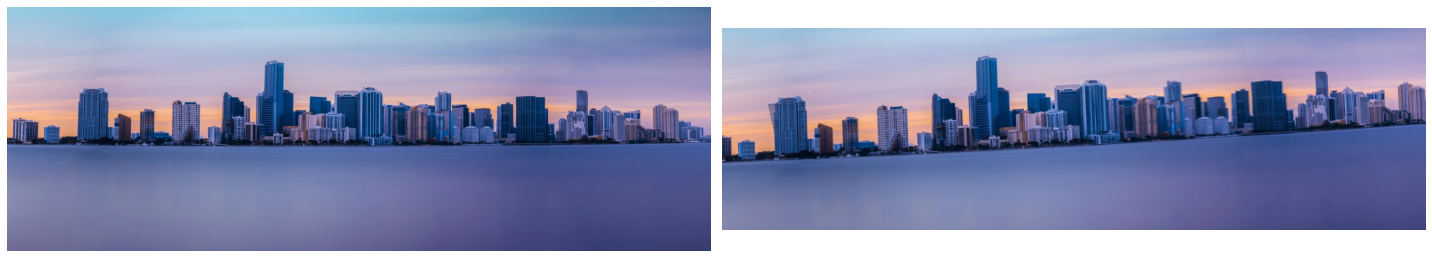

In [ ]:
show_images([img, cropped_img], show_axis=False)